In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, fftpack
from scipy import signal as sig
from random import choice

PATH = '/Users/carterdemars/Desktop/pv_data/pv_time_series.csv'

In [2]:
pv_df = pd.read_csv(PATH)

In [3]:
pv_df.head()

,system_id,timestamp,instantaneous_power_W,temperature_C,voltage
0,10441,2015-01-01 08:00:00,108.000000,2.933333,231.000000
1,10441,2015-01-01 08:15:00,573.333333,3.233333,229.333333
2,10441,2015-01-01 08:30:00,780.000000,6.000000,230.333333
3,10441,2015-01-01 08:45:00,1002.666667,3.666667,232.000000
4,10441,2015-01-01 09:00:00,1264.333333,8.133333,231.666667


# TODO: probably not ideal to pick a random site given that some sites have poor data

In [8]:
sample_site = pv_df[pv_df['system_id'] == choice(pv_df['system_id'].unique())]

In [5]:
sample_site.head()

,system_id,timestamp,instantaneous_power_W,temperature_C,voltage
16045276,36554,2015-04-13 10:45:00,10386.000000,49.680000,236.6
16045277,36554,2015-04-13 11:00:00,10404.000000,50.276667,NaN
16045278,36554,2015-04-13 11:15:00,10558.000000,51.446667,NaN
16045279,36554,2015-04-13 11:30:00,10763.000000,52.520000,NaN
16045280,36554,2015-04-13 11:45:00,11319.333333,53.923333,NaN


In [6]:
from datetime import datetime
sample_site['timestamp'] = sample_site['timestamp'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())

/var/folders/7g/4cb0n6ln6dj_vbm8hpn1jcsm0000gn/T/ipykernel_42909/3408435467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_site['timestamp'] = sample_site['timestamp'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())


In [6]:
daily_max = sample_site.groupby('timestamp')['instantaneous_power_W'].max().rolling(30).mean()
daily_avg = sample_site.groupby('timestamp')['instantaneous_power_W'].mean().rolling(30).mean()

In [7]:
sns.lineplot(daily_max)

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

Error in callback <function flush_figures at 0x1c60eef70> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

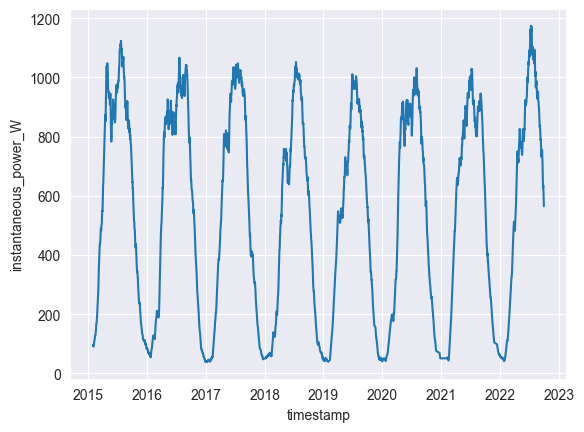

In [9]:
sns.lineplot(daily_avg)

In [10]:
all_site_agg = pv_df.groupby('timestamp')['instantaneous_power_W'].mean()

In [18]:
all_site_agg.rolling(100).mean().tail(100)

timestamp
2022-09-30 23:00:00     635.117672
2022-09-30 23:15:00     635.060635
2022-09-30 23:30:00     635.004524
2022-09-30 23:45:00     634.948043
2022-10-01 00:00:00     634.926228
                          ...     
2022-10-01 22:45:00    1213.616956
2022-10-01 23:00:00    1213.742286
2022-10-01 23:15:00    1213.904247
2022-10-01 23:30:00    1214.083256
2022-10-01 23:45:00    1214.262265
Name: instantaneous_power_W, Length: 100, dtype: float64

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

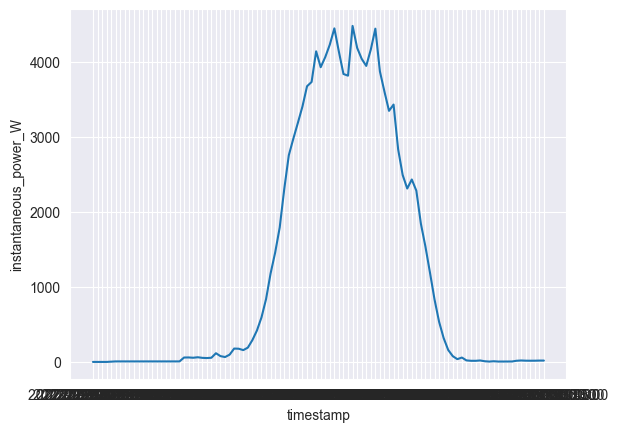

In [19]:
sns.lineplot(all_site_agg.tail(100))

# TODO: clean up this code

In [55]:

sample_site = pv_df.groupby('timestamp')['instantaneous_power_W'].mean()
# sample_site.index = sample_site['timestamp'].apply(lambda d: datetime.strptime(d,'%Y-%m-%d %H:%M:%S'))

In [75]:
#sample_site.index.name = 'time'
# sample_site['timestamp'] = sample_site.index.apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
#sample_site.index = sample_site['time'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
s = sample_site.to_frame()
s.index = pd.Series(s.index).apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
sample_site = s.groupby(s.index.name)['instantaneous_power_W'].max()

In [ ]:
sample_site

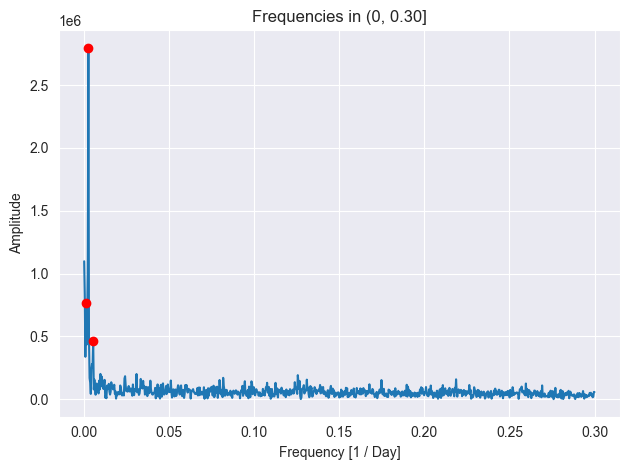

In [99]:
# Fourier Features
time_index =  pd.Series([i for i in range (len(sample_site.index))])
series = sample_site.values

fft_output = fftpack.fft(series)
power = np.abs(fft_output)
freq = fft.fftfreq(len(series))

mask = (freq > 0) & (freq <= 0.3)
plt.plot(freq[mask], power[mask])
plt.title('Frequencies in (0, 0.30]')
plt.ylabel( 'Amplitude' )
plt.xlabel( 'Frequency [1 / Day]' )

peaks = sig.find_peaks(power[freq >=0], prominence=3e5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()

In [100]:
peak_freq

array([0.00141293, 0.00282586, 0.00565171])

In [101]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/day)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

In [102]:
output

,index,freq (1/day),amplitude,period (days),fft
1,8,0.002826,2.796039e+06,353.8750,-2.386418e+06+1.456999e+06j
0,4,0.001413,7.670274e+05,707.7500,2.371798e+05-7.294359e+05j
2,16,0.005652,4.655987e+05,176.9375,-2.812223e+05+3.710743e+05j


In [103]:
filtered_fft_output = np.array([f if i in [8, 4, 16] else 0 for i, f in enumerate(fft_output)])
filtered_sig = fftpack.ifft(filtered_fft_output)

In [104]:
filtered_sig

array([-858.51660226+388.07395288j, -869.82810074+370.17104831j,
       -880.746764  +351.97017169j, ..., -822.31076623+439.90377831j,
       -834.74913011+422.94916275j, -846.82071588+405.66965013j])

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


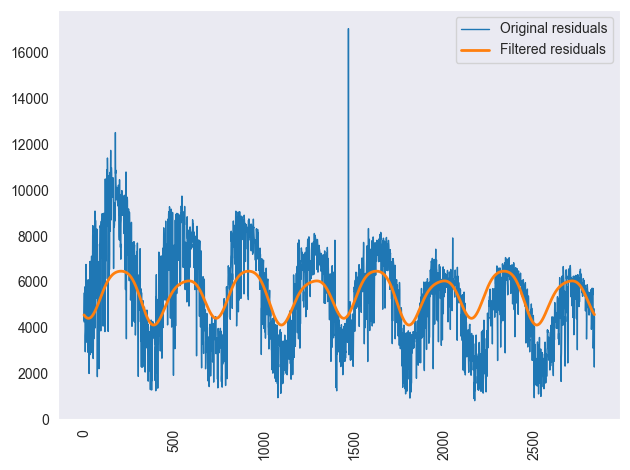

In [105]:
plt.plot(time_index, series, linewidth=1, label='Original residuals')
plt.plot(time_index, filtered_sig+series.mean(), linewidth=2, label='Filtered residuals')
plt.legend(loc='upper right')
plt.grid()

plt.xticks(rotation=90)
plt.tight_layout()

# TODO: fix these coefficients to match current data

In [106]:
import cmath
A1, f1, = 0.75, 0.002791
phase = cmath.phase(194.102798-167.651352j)
y1 = A1 * np.sin(2*np.pi * f1 * time_index - phase)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot: xlabel='time'>

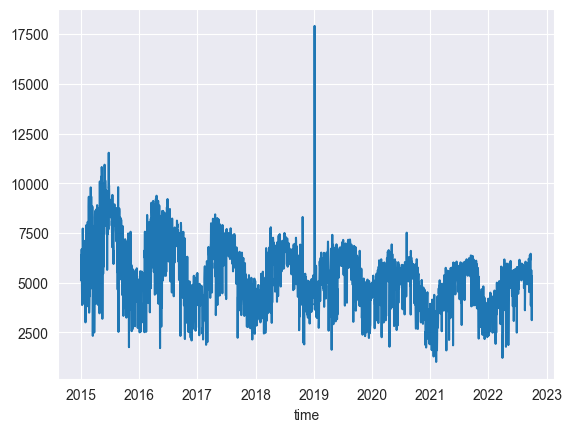

In [107]:
new_data = series - filtered_sig
sns.lineplot(x=sample_site.index, y=new_data)

***Note***: some preprocessing still needs to be done to remove outliers before this point in the notebook

TODO: temporal encoding & seasonality representation for yearly data
1) Aggregate data from across years by day and time
2) Aggregate data within each day by maximum PV output
3) Convert absolute PV output to relative PV output (0-1 scale)
4) Use SARIMA, Fourier features, or polynomial fits to model yearly seasonality

TODO: temporal encoding & seasonality representation for intraday data
1) Aggregate data from across years by day and time
2) Seasonally adjust the data using yearly representation
3) Convert absolute PV output to relative PV output (0-1 scale)
4) Use SARIMA, Fourier features, or polynomial fits to model daily seasonality

Then, we can generate a function f(time of day, day of year) = expected PV output

We can select a sample site for this proof of concept. The following site was chosen because it had the most data points out of all sites.

In [55]:
sample_site = pv_df[pv_df['system_id'] == 32779].reset_index()

### Seasonality for yearly data

We first aggregate data from across years by month

In [56]:
sample_site['timestamp'] = sample_site['timestamp'].apply(lambda t: t[5:])
sample_site = sample_site.groupby('timestamp').mean()

In [65]:
pv_output = sample_site['instantaneous_power_W']

Then we take the maximum datapoints for each day

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

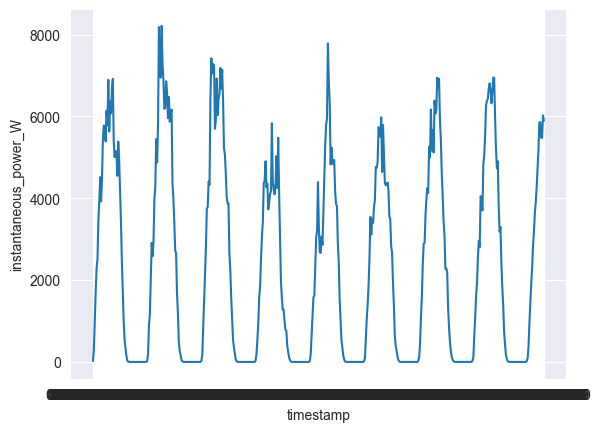

In [68]:
sns.lineplot(pv_output[:500])